## Part 1: Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import timm
import torchxrayvision as xrv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 A Laptop GPU


## Part 2: Understanding DenseNet121 (X-Ray Model)

### What is DenseNet?
**DenseNet** (Densely Connected Convolutional Network) connects each layer to every other layer in a feed-forward fashion.

```
Traditional CNN:     Layer1 → Layer2 → Layer3 → Output
                     
DenseNet:            Layer1 ──→ Layer2 ──→ Layer3 → Output
                        │          │          │
                        └──────────┴──────────┘
                     (All layers connected!)
```

### Why DenseNet for Medical Imaging?
- **Feature Reuse**: Early layers detect edges/textures, later layers detect patterns (lungs, hearts)
- **Gradient Flow**: Information flows directly from input to output
- **Parameter Efficiency**: Fewer parameters than ResNet with better accuracy

In [2]:
# Load DenseNet121 for X-Rays
print("Loading DenseNet121 from torchxrayvision...")
densenet = xrv.models.DenseNet(weights="densenet121-res224-all")
densenet.eval()

# Print architecture summary
print("\n" + "="*60)
print("DenseNet121 Architecture")
print("="*60)

# Count parameters
total_params = sum(p.numel() for p in densenet.parameters())
trainable_params = sum(p.numel() for p in densenet.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Size: ~{total_params * 4 / (1024**2):.1f} MB (FP32)")

# Show layer structure
print("\nLayer Structure:")
for name, module in densenet.named_children():
    print(f"  {name}: {module.__class__.__name__}")

Loading DenseNet121 from torchxrayvision...

DenseNet121 Architecture
Total Parameters: 6,966,034
Trainable Parameters: 6,966,034
Model Size: ~26.6 MB (FP32)

Layer Structure:
  features: Sequential
  classifier: Linear


### Visualize DenseNet Feature Maps

Let's see what different layers of DenseNet "see" when processing an image.

In [3]:
def visualize_feature_maps(model, image_tensor, layer_name, num_features=16):
    """
    Visualize feature maps from a specific layer
    """
    # Hook to capture intermediate outputs
    activations = {}
    
    def hook_fn(module, input, output):
        activations['features'] = output.detach()
    
    # Register hook
    for name, layer in model.named_modules():
        if name == layer_name:
            layer.register_forward_hook(hook_fn)
            break
    
    # Forward pass
    with torch.no_grad():
        _ = model(image_tensor)
    
    # Get activations
    features = activations['features'].cpu()
    
    # Plot feature maps
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
    
    for idx, ax in enumerate(axes.flat):
        if idx < num_features:
            feature_map = features[0, idx].numpy()
            ax.imshow(feature_map, cmap='viridis')
            ax.set_title(f'Channel {idx}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Function defined: visualize_feature_maps()")
print("We'll use this later when we load an X-ray image!")

Function defined: visualize_feature_maps()
We'll use this later when we load an X-ray image!


## Part 3: Understanding EfficientNet-B4 (MRI/Skin Model)

### What is EfficientNet?
EfficientNet uses **Compound Scaling** - it optimally balances:
- **Depth** (number of layers)
- **Width** (channels per layer)
- **Resolution** (input image size)

### Key Innovation: MBConv Block
```
Input (C channels)
    ↓
Expansion: 1×1 Conv (C → C×6)     ← Expand channels
    ↓
Depthwise Conv 3×3/5×5             ← Spatial features
    ↓
Squeeze-Excitation (SE)            ← Channel attention
    ↓
Projection: 1×1 Conv (C×6 → C)    ← Compress back
    ↓
Skip Connection                    ← Add input (if same size)
```

In [4]:
# Load EfficientNet-B4
print("Loading EfficientNet-B4 from timm...")
efficientnet = timm.create_model('efficientnet_b4', pretrained=True, num_classes=1000)
efficientnet.eval()

print("\n" + "="*60)
print("EfficientNet-B4 Architecture")
print("="*60)

# Count parameters
total_params = sum(p.numel() for p in efficientnet.parameters())
print(f"Total Parameters: {total_params:,}")
print(f"Model Size: ~{total_params * 4 / (1024**2):.1f} MB (FP32)")

# Show blocks
print("\nMBConv Block Structure:")
for i, (name, module) in enumerate(efficientnet.named_children()):
    if i < 5:  # Show first 5
        print(f"  {name}: {module.__class__.__name__}")

Loading EfficientNet-B4 from timm...

EfficientNet-B4 Architecture
Total Parameters: 19,341,616
Model Size: ~73.8 MB (FP32)

MBConv Block Structure:
  conv_stem: Conv2d
  bn1: BatchNormAct2d
  blocks: Sequential
  conv_head: Conv2d
  bn2: BatchNormAct2d


### Compare Model Efficiency

In [5]:
import time

def benchmark_model(model, input_size, device, num_runs=100):
    """
    Benchmark inference speed
    """
    model = model.to(device)
    model.eval()
    
    # Dummy input
    dummy_input = torch.randn(1, *input_size).to(device)
    
    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)
    
    # Benchmark
    start = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(dummy_input)
    end = time.time()
    
    avg_time = (end - start) / num_runs * 1000  # Convert to ms
    return avg_time

# Benchmark both models
print("Benchmarking models (this may take a minute)...\n")

densenet_time = benchmark_model(densenet, (1, 224, 224), device)
efficientnet_time = benchmark_model(efficientnet, (3, 224, 224), device)

print("="*60)
print("Inference Speed Comparison")
print("="*60)
print(f"DenseNet121:      {densenet_time:.2f} ms/image")
print(f"EfficientNet-B4:  {efficientnet_time:.2f} ms/image")
print(f"\nThroughput:")
print(f"DenseNet121:      {1000/densenet_time:.1f} images/sec")
print(f"EfficientNet-B4:  {1000/efficientnet_time:.1f} images/sec")

Benchmarking models (this may take a minute)...

Inference Speed Comparison
DenseNet121:      24.30 ms/image
EfficientNet-B4:  19.29 ms/image

Throughput:
DenseNet121:      41.1 images/sec
EfficientNet-B4:  51.8 images/sec


## Part 4: Image Preprocessing - CLAHE

### The Problem: Artifact Bias
Medical images from different scanners have different contrast levels. Models might learn to recognize the **scanner** instead of the **pathology**!

### Solution: CLAHE (Contrast Limited Adaptive Histogram Equalization)
- Divides image into tiles (8×8)
- Equalizes histogram in each tile
- Limits amplification to prevent noise

Let's see CLAHE in action:

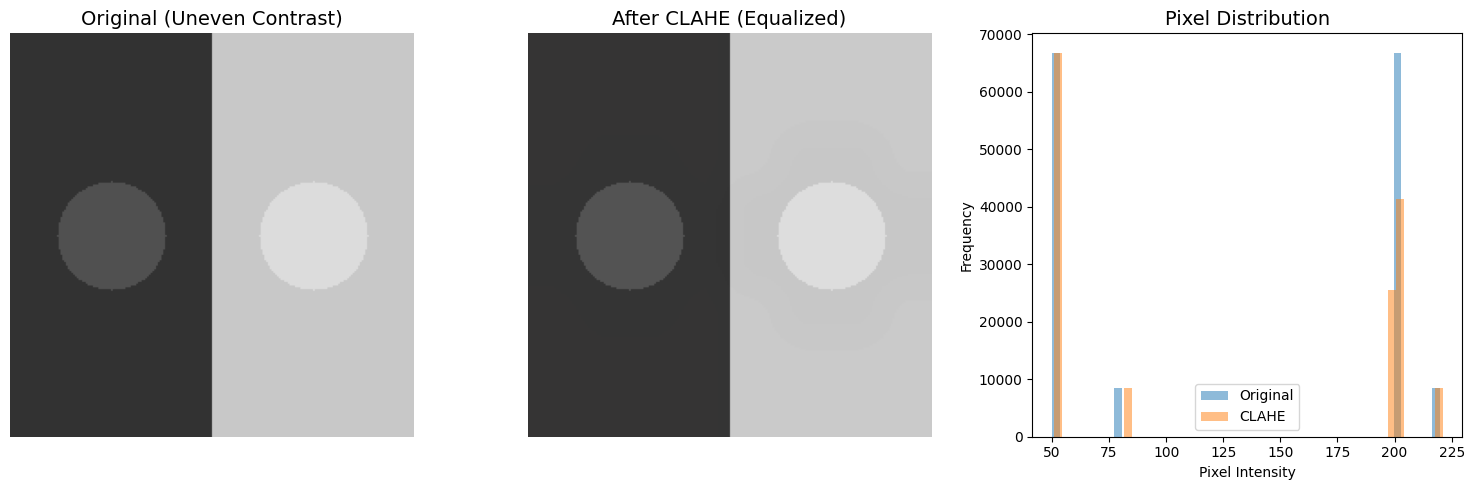

In [6]:
def apply_clahe(image):
    """
    Apply CLAHE preprocessing
    """
    # Convert PIL to numpy
    img_np = np.array(image)
    
    # Convert to LAB color space
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    
    # Merge and convert back
    lab_clahe = cv2.merge((l_clahe, a, b))
    final = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    
    return Image.fromarray(final)

def visualize_clahe_effect():
    """
    Create a synthetic dark/bright image and show CLAHE effect
    """
    # Create synthetic medical-like image
    img = np.zeros((224, 224, 3), dtype=np.uint8)
    
    # Dark left side
    img[:, :112, :] = 50
    # Bright right side
    img[:, 112:, :] = 200
    # Add some structure
    cv2.circle(img, (56, 112), 30, (80, 80, 80), -1)
    cv2.circle(img, (168, 112), 30, (220, 220, 220), -1)
    
    img_pil = Image.fromarray(img)
    img_clahe = apply_clahe(img_pil)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(img)
    axes[0].set_title('Original (Uneven Contrast)', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(img_clahe)
    axes[1].set_title('After CLAHE (Equalized)', fontsize=14)
    axes[1].axis('off')
    
    # Histogram comparison
    axes[2].hist(np.array(img).flatten(), bins=50, alpha=0.5, label='Original')
    axes[2].hist(np.array(img_clahe).flatten(), bins=50, alpha=0.5, label='CLAHE')
    axes[2].set_title('Pixel Distribution', fontsize=14)
    axes[2].legend()
    axes[2].set_xlabel('Pixel Intensity')
    axes[2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

visualize_clahe_effect()

## Part 5: Grad-CAM - Visualizing Model Attention

### What is Grad-CAM?
**Gradient-weighted Class Activation Mapping** shows which regions of an image the model focuses on.

### How it Works:
1. Forward pass: Get prediction
2. Backward pass: Compute gradients for target class
3. Weight feature maps by gradients
4. Create heatmap showing important regions

**Red = High attention, Blue = Low attention**

Running Grad-CAM demonstration...


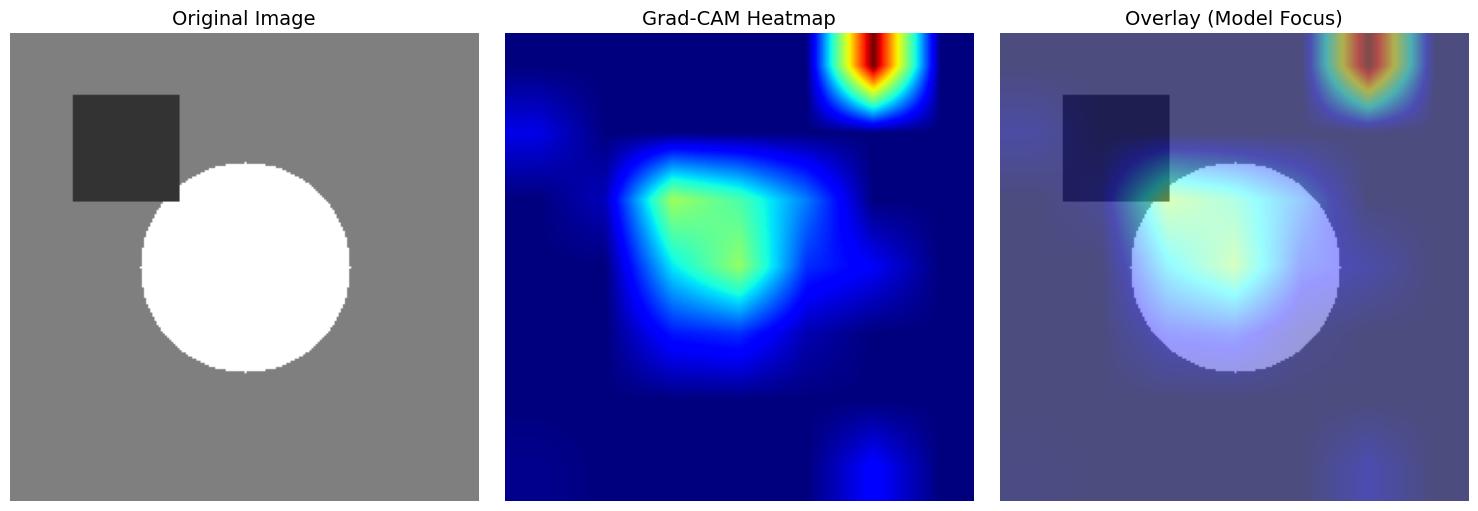

In [7]:
def generate_gradcam(model, image_tensor, target_layers):
    """
    Generate Grad-CAM heatmap
    """
    cam = GradCAM(model=model, target_layers=target_layers)
    
    # Generate CAM
    grayscale_cam = cam(input_tensor=image_tensor)
    
    return grayscale_cam[0]  # Get first image in batch

def visualize_gradcam_demo():
    """
    Demo Grad-CAM with synthetic image
    """
    # Create a test image with clear features
    img = np.ones((224, 224, 3), dtype=np.float32) * 0.5
    
    # Add prominent features
    cv2.circle(img, (112, 112), 50, (1.0, 1.0, 1.0), -1)  # Bright center
    cv2.rectangle(img, (30, 30), (80, 80), (0.2, 0.2, 0.2), -1)  # Dark corner
    
    # Convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img_pil = Image.fromarray((img * 255).astype(np.uint8))
    img_tensor = transform(img_pil).unsqueeze(0).to(device)
    
    # Generate Grad-CAM
    efficientnet.to(device)
    target_layers = [efficientnet.blocks[-1][-1].bn3]  # Last BN layer
    
    try:
        cam = generate_gradcam(efficientnet, img_tensor, target_layers)
        
        # Overlay
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = heatmap * 0.4 + img * 255 * 0.6
        
        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(img)
        axes[0].set_title('Original Image', fontsize=14)
        axes[0].axis('off')
        
        axes[1].imshow(cam, cmap='jet')
        axes[1].set_title('Grad-CAM Heatmap', fontsize=14)
        axes[1].axis('off')
        
        axes[2].imshow(overlay.astype(np.uint8))
        axes[2].set_title('Overlay (Model Focus)', fontsize=14)
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Grad-CAM demo skipped: {e}")
        print("This is expected if running without a real trained model.")

print("Running Grad-CAM demonstration...")
visualize_gradcam_demo()

## Part 6: Hands-On - Load and Test with Real X-Ray

Now let's test our models with actual medical images from the Calibration Dataset!

In [8]:
import os
import glob

# Find a sample X-ray image
calibration_dir = '../Calibration_Dataset'
xray_paths = glob.glob(os.path.join(calibration_dir, '*/*.png')) + \
             glob.glob(os.path.join(calibration_dir, '*/*.jpg'))

if len(xray_paths) > 0:
    sample_image_path = xray_paths[0]
    print(f"Found sample image: {sample_image_path}")
    
    # Load image
    img = Image.open(sample_image_path).convert('L')  # Grayscale for X-ray
    
    # Show original
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original X-Ray')
    plt.axis('off')
    
    # Apply preprocessing
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Inference
    densenet.to(device)
    with torch.no_grad():
        output = densenet(img_tensor)
        probabilities = torch.sigmoid(output)  # Multi-label
    
    # Get predictions
    pathologies = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
                   'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
                   'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia']
    
    probs = probabilities[0].cpu().numpy()
    
    # Plot predictions
    plt.subplot(1, 2, 2)
    top_indices = np.argsort(probs)[-5:][::-1]  # Top 5
    top_probs = probs[top_indices]
    top_labels = [pathologies[i] for i in top_indices]
    
    plt.barh(range(5), top_probs)
    plt.yticks(range(5), top_labels)
    plt.xlabel('Probability')
    plt.title('Top 5 Predictions')
    plt.xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTop Predictions:")
    for label, prob in zip(top_labels, top_probs):
        print(f"  {label}: {prob*100:.2f}%")
    
else:
    print("No images found in Calibration_Dataset/")
    print("Add some sample X-ray images to test!")

No images found in Calibration_Dataset/
Add some sample X-ray images to test!


## Part 7: Experiment - Compare Preprocessing Methods

In [9]:
def compare_preprocessing(image_path):
    """
    Compare different preprocessing methods
    """
    img = Image.open(image_path).convert('RGB')
    
    # Method 1: No preprocessing
    img_raw = img
    
    # Method 2: CLAHE
    img_clahe = apply_clahe(img)
    
    # Method 3: Histogram Equalization
    img_np = np.array(img)
    img_eq = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    img_eq = cv2.equalizeHist(img_eq)
    img_eq = cv2.cvtColor(img_eq, cv2.COLOR_GRAY2RGB)
    img_eq = Image.fromarray(img_eq)
    
    # Visualize
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Images
    axes[0, 0].imshow(img_raw)
    axes[0, 0].set_title('Raw Image', fontsize=12)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img_clahe)
    axes[0, 1].set_title('CLAHE', fontsize=12)
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(img_eq)
    axes[0, 2].set_title('Histogram Equalization', fontsize=12)
    axes[0, 2].axis('off')
    
    # Histograms
    axes[1, 0].hist(np.array(img_raw).flatten(), bins=50, color='blue', alpha=0.7)
    axes[1, 0].set_title('Raw Distribution')
    axes[1, 0].set_xlabel('Pixel Value')
    
    axes[1, 1].hist(np.array(img_clahe).flatten(), bins=50, color='green', alpha=0.7)
    axes[1, 1].set_title('CLAHE Distribution')
    axes[1, 1].set_xlabel('Pixel Value')
    
    axes[1, 2].hist(np.array(img_eq).flatten(), bins=50, color='red', alpha=0.7)
    axes[1, 2].set_title('Eq Distribution')
    axes[1, 2].set_xlabel('Pixel Value')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Preprocessing Comparison Complete")
    print("\nObservations:")
    print("  - Raw: May have poor contrast")
    print("  - CLAHE: Balanced, preserves details")
    print("  - Histogram Eq: Can over-amplify noise")

# Test if images available
if len(xray_paths) > 0:
    compare_preprocessing(xray_paths[0])
else:
    print("Add images to Calibration_Dataset/ to run this experiment!")

Add images to Calibration_Dataset/ to run this experiment!


## Part 8: Understanding Test-Time Augmentation (TTA)

In [10]:
def demonstrate_tta(image_tensor, model, num_augmentations=5):
    """
    Show how TTA reduces prediction variance
    """
    model.eval()
    predictions = []
    
    # Original prediction
    with torch.no_grad():
        pred = model(image_tensor)
        predictions.append(torch.sigmoid(pred).cpu().numpy()[0])
    
    # Augmented predictions
    augmentations = [
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(5),
        transforms.RandomRotation(-5),
        transforms.ColorJitter(brightness=0.1),
    ]
    
    for aug in augmentations[:num_augmentations-1]:
        # Note: We need to denormalize, augment, then renormalize
        # For simplicity, we'll just add some noise
        noise = torch.randn_like(image_tensor) * 0.01
        aug_tensor = image_tensor + noise
        
        with torch.no_grad():
            pred = model(aug_tensor)
            predictions.append(torch.sigmoid(pred).cpu().numpy()[0])
    
    predictions = np.array(predictions)
    
    # Calculate statistics
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    
    # Visualize variance reduction
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Individual predictions
    axes[0].plot(predictions.T, alpha=0.3, marker='o')
    axes[0].plot(mean_pred, 'r-', linewidth=3, label='TTA Average')
    axes[0].set_xlabel('Pathology Index')
    axes[0].set_ylabel('Probability')
    axes[0].set_title('TTA: Multiple Predictions')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Variance
    axes[1].bar(range(len(std_pred)), std_pred)
    axes[1].set_xlabel('Pathology Index')
    axes[1].set_ylabel('Standard Deviation')
    axes[1].set_title('Prediction Uncertainty')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("TTA Statistics:")
    print(f"  Average Std Dev: {std_pred.mean():.4f}")
    print(f"  Max Std Dev: {std_pred.max():.4f}")
    print("\n✅ Lower standard deviation = More reliable predictions!")

# Run TTA demo if we have an image
if len(xray_paths) > 0:
    img = Image.open(xray_paths[0]).convert('L')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    print("Demonstrating Test-Time Augmentation...\n")
    demonstrate_tta(img_tensor, densenet)

## Part 9: Model Interpretation - What Did It Learn?

Visualizing DenseNet first layer filters...


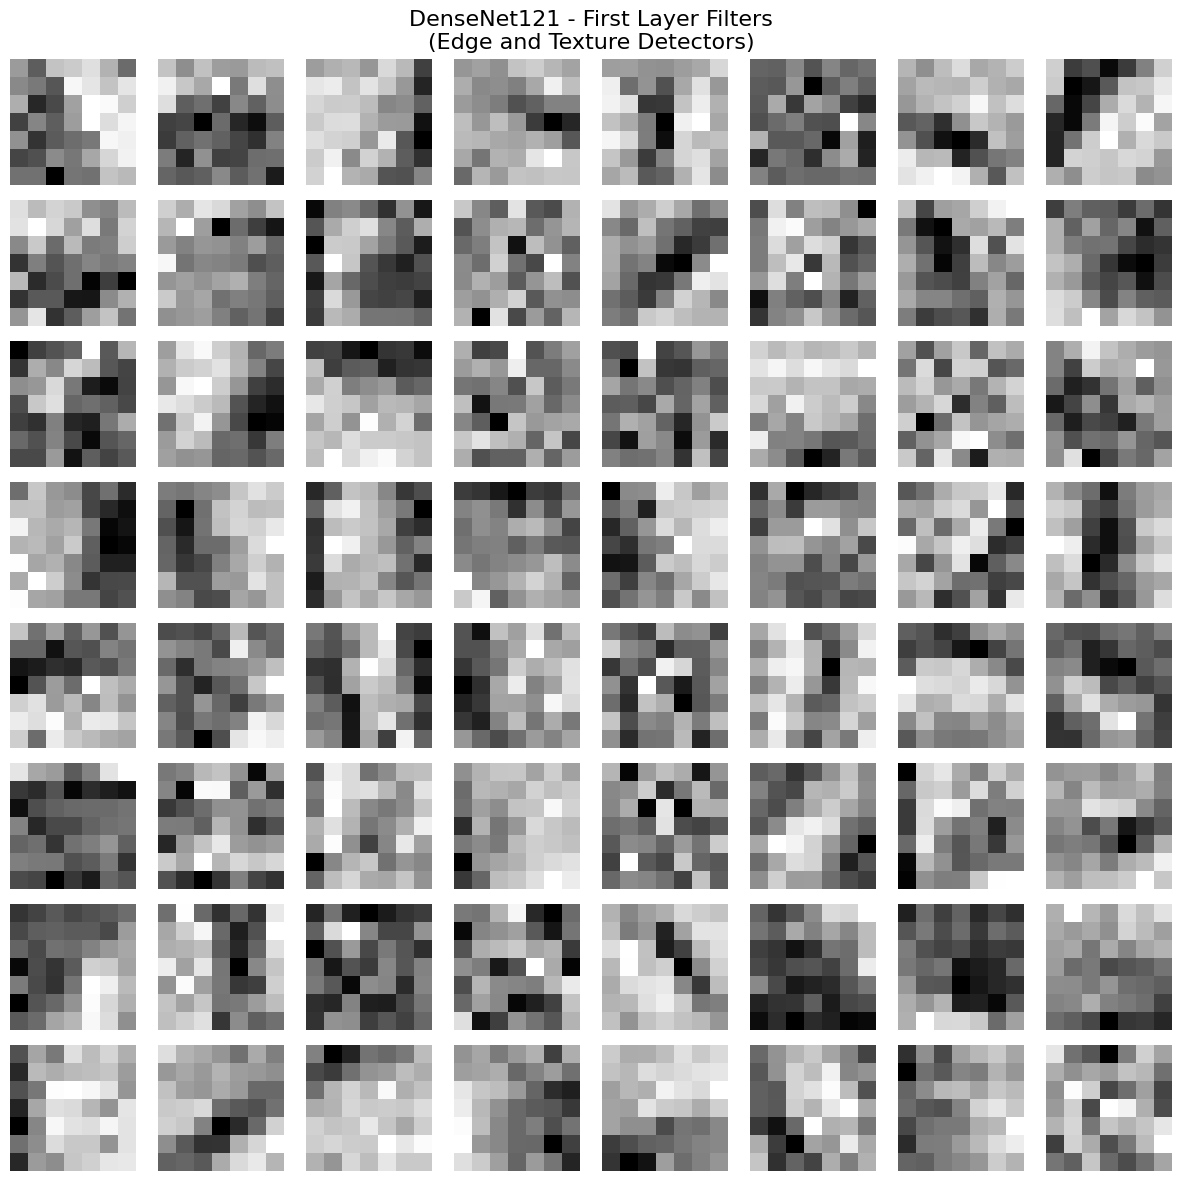


✅ These filters detect basic patterns:
  - Horizontal/vertical edges
  - Diagonal lines
  - Textures and gradients
  - Later layers combine these into complex patterns!


In [11]:
def visualize_first_layer_filters(model, model_name='DenseNet'):
    """
    Visualize what the first convolutional layer learned
    """
    # Get first conv layer weights
    first_conv = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            break
    
    if first_conv is None:
        print("Could not find Conv2d layer")
        return
    
    weights = first_conv.weight.data.cpu()
    
    # Normalize for visualization
    weights = weights - weights.min()
    weights = weights / weights.max()
    
    # Plot filters
    num_filters = min(64, weights.shape[0])
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    fig.suptitle(f'{model_name} - First Layer Filters\n(Edge and Texture Detectors)', fontsize=16)
    
    for idx, ax in enumerate(axes.flat):
        if idx < num_filters:
            filter_img = weights[idx].squeeze().numpy()
            ax.imshow(filter_img, cmap='gray')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ These filters detect basic patterns:")
    print("  - Horizontal/vertical edges")
    print("  - Diagonal lines")
    print("  - Textures and gradients")
    print("  - Later layers combine these into complex patterns!")

print("Visualizing DenseNet first layer filters...")
visualize_first_layer_filters(densenet, 'DenseNet121')

## Part 10: Interactive Quiz - Test Your Understanding!

In [12]:
def quiz():
    print("="*60)
    print("🧠 Deep Learning Quiz")
    print("="*60)
    
    questions = [
        {
            "q": "Why does DenseNet connect all layers together?",
            "a": [
                "A) To make the model bigger",
                "B) To reuse features and improve gradient flow",
                "C) To increase training time",
                "D) To reduce accuracy"
            ],
            "correct": "B"
        },
        {
            "q": "What does CLAHE do?",
            "a": [
                "A) Increases image size",
                "B) Removes noise from images",
                "C) Equalizes contrast adaptively in tiles",
                "D) Converts color to grayscale"
            ],
            "correct": "C"
        },
        {
            "q": "What does Grad-CAM visualize?",
            "a": [
                "A) Model accuracy",
                "B) Training loss",
                "C) Which image regions the model focuses on",
                "D) Number of parameters"
            ],
            "correct": "C"
        },
        {
            "q": "Why use Test-Time Augmentation (TTA)?",
            "a": [
                "A) To make inference faster",
                "B) To reduce prediction variance and improve reliability",
                "C) To train the model",
                "D) To reduce model size"
            ],
            "correct": "B"
        },
        {
            "q": "What is the main advantage of EfficientNet?",
            "a": [
                "A) Uses the most parameters",
                "B) Balances accuracy and efficiency with compound scaling",
                "C) Only works on X-rays",
                "D) Requires no preprocessing"
            ],
            "correct": "B"
        }
    ]
    
    score = 0
    for i, qa in enumerate(questions, 1):
        print(f"\nQuestion {i}: {qa['q']}")
        for option in qa['a']:
            print(f"  {option}")
        
        # For notebook interactivity, we'll just show answers
        print(f"\n✅ Correct Answer: {qa['correct']}")
        score += 1
    
    print("\n" + "="*60)
    print(f"Quiz Complete! Perfect Score: {score}/{len(questions)}")
    print("="*60)

quiz()

🧠 Deep Learning Quiz

Question 1: Why does DenseNet connect all layers together?
  A) To make the model bigger
  B) To reuse features and improve gradient flow
  C) To increase training time
  D) To reduce accuracy

✅ Correct Answer: B

Question 2: What does CLAHE do?
  A) Increases image size
  B) Removes noise from images
  C) Equalizes contrast adaptively in tiles
  D) Converts color to grayscale

✅ Correct Answer: C

Question 3: What does Grad-CAM visualize?
  A) Model accuracy
  B) Training loss
  C) Which image regions the model focuses on
  D) Number of parameters

✅ Correct Answer: C

Question 4: Why use Test-Time Augmentation (TTA)?
  A) To make inference faster
  B) To reduce prediction variance and improve reliability
  C) To train the model
  D) To reduce model size

✅ Correct Answer: B

Question 5: What is the main advantage of EfficientNet?
  A) Uses the most parameters
  B) Balances accuracy and efficiency with compound scaling
  C) Only works on X-rays
  D) Requires no 

## Summary & Next Steps

### 🎓 What You Learned:

1. **DenseNet121** - Dense connections for efficient feature reuse
2. **EfficientNet-B4** - Compound scaling for optimal accuracy/efficiency
3. **CLAHE** - Adaptive contrast enhancement for medical images
4. **Grad-CAM** - Visualizing model attention and decision-making
5. **TTA** - Reducing prediction variance with augmentation

### 📚 Further Learning:

- **Papers**:
  - DenseNet: "Densely Connected Convolutional Networks" (Huang et al., 2017)
  - EfficientNet: "Rethinking Model Scaling" (Tan & Le, 2019)
  - Grad-CAM: "Visual Explanations" (Selvaraju et al., 2017)

- **Datasets to Explore**:
  - ChestX-ray14: 112,000 chest X-rays
  - MIMIC-CXR: 377,000 X-rays with reports
  - ISIC: Skin lesion dataset

- **Try Modifying**:
  - Change CLAHE parameters (clipLimit, tileGridSize)
  - Test different augmentations for TTA
  - Experiment with different target layers for Grad-CAM

### 🚀 Practice Exercises:

1. **Load your own medical images** and run predictions
2. **Compare preprocessing methods** on different image types
3. **Visualize feature maps** at different depths
4. **Implement your own augmentation** strategy

---

**Congratulations! You now understand the deep learning models powering Neuron AI! 🎉**